In [1]:
%pylab inline

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO: 2016-06-29 11:27:36,612 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [100]:
import time

In [114]:
logger.setLevel(logging.INFO)

In [4]:
%time ri = hardware_tools.r2_with_mk1()

DEBUG: 2016-06-29 11:27:39,328 - kid_readout.roach.interface.__init__:65  Creating FpgaClient
DEBUG: 2016-06-29 11:27:39,329 - kid_readout.roach.interface.__init__:69  Waiting for connection to ROACH
DEBUG: 2016-06-29 11:27:39,330 - kid_readout.roach.interface.__init__:74  ROACH is connected
INFO: 2016-06-29 11:27:40,184 - kid_readout.roach.interface.initialize:411  Loaded ROACH state from /data/readout/r2kid_config.npz
DEBUG: 2016-06-29 11:27:40,188 - kid_readout.roach.interface.initialize:420  Programmed boffile crc: -18100485
DEBUG: 2016-06-29 11:27:40,221 - kid_readout.roach.r2heterodyne.initialize:55  Stopped tap interface
DEBUG: 2016-06-29 11:27:40,287 - kid_readout.roach.r2heterodyne.initialize:59  Started tap interface
DEBUG: 2016-06-29 11:27:40,289 - kid_readout.roach.r2heterodyne.initialize:61  Checking QDR calibration
DEBUG: 2016-06-29 11:27:40,358 - kid_readout.roach.r2heterodyne.initialize:66  QDR is calibrated


CPU times: user 819 ms, sys: 57 ms, total: 876 ms
Wall time: 1.33 s


In [10]:
ri.set_loopback(False)

In [83]:
ri.iq_delay=-1

In [127]:
ri.set_lo(1810.)

In [120]:
ri.set_tone_baseband_freqs(np.hstack((np.linspace(-220,-10,8),np.linspace(10,220,8)+2)),nsamp=2**16)

array([-220., -190., -160., -130., -100.,  -70.,  -40.,  -10.,   12.,
         42.,   72.,  102.,  132.,  162.,  192.,  222.])

In [108]:
ri.tone_baseband_frequencies.shape

(1, 16)

In [109]:
ri.set_dac_atten(20)

In [152]:
def find_best_iq_delay_adc(ri,iq_delay_range=np.arange(-4,4), do_plot=False):
    tone_baseband_frequencies = ri.tone_baseband_frequencies
    total_rejections = []
    for iq_delay in iq_delay_range:
        ri.iq_delay = iq_delay
        ri.set_tone_baseband_freqs(tone_baseband_frequencies,ri.tone_nsamp)
#        time.sleep(0.1)
        x,y = ri.get_raw_adc()
        pxx,fr = mlab.psd(x+1j*y,Fs=ri.fs,NFFT=512)
        rejections = []
        for idx,tone in enumerate(tone_baseband_frequencies[0,:]):
            signal = dB(pxx[np.argmin(np.abs(fr-tone))],as_power=False)
            image = dB(pxx[np.argmin(np.abs(fr+tone))],as_power=False)
            rejection = signal-image
            logger.debug("\nAt iq_delay: %d, tone: %.1f MHz, signal: %.1f dB, image %.1f dB, rejection %.1f dB" % 
                       (iq_delay, tone, signal, image, rejection))
            rejections.append(rejection)
        total_rejections.append(np.median(rejections))
    best = np.argmax(total_rejections)
    logger.info("Best delay is %d with median rejection %.1f dB" % (iq_delay_range[best],total_rejections[best]))
    if do_plot:
        plt.plot(iq_delay_range,total_rejections)
    return iq_delay_range[best], total_rejections[best]

In [153]:
ri.set_loopback(False)

In [155]:
import valon_synth

In [156]:
valon_synth.__file__

'/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/valon_synth/__init__.pyc'

INFO: 2016-06-29 13:24:31,079 - kid_readout.find_best_iq_delay_adc:20  Best delay is 0 with median rejection 19.1 dB


CPU times: user 310 ms, sys: 40 ms, total: 350 ms
Wall time: 948 ms


0

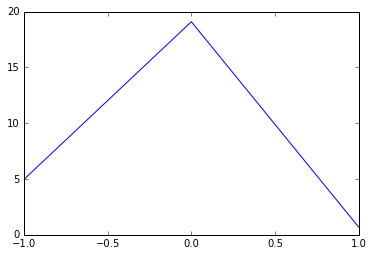

In [154]:
%time find_best_iq_delay_adc(ri,[-1,0,1])

In [133]:
x,y = ri.get_raw_adc()

In [143]:
hx,b = np.histogram(x,bins=np.arange(-2048,2048,16))
hy,b = np.histogram(y,bins=np.arange(-2048,2048,16))


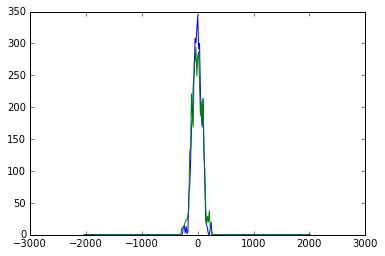

In [144]:
plot(b[:-1],hx)
plot(b[:-1],hy)
#xlim(-100,100)

In [94]:
pxx,fr = mlab.psd(x+1j*y,Fs=512.,NFFT=512)

In [99]:
10*np.log10(pxx[np.argmin(np.abs(fr-65))]/pxx[np.argmin(np.abs(fr+65))])

17.548255444561278

In [98]:
10*np.log10(pxx[np.argmin(np.abs(fr-130))]/pxx[np.argmin(np.abs(fr+130))])

-21.962146372515669

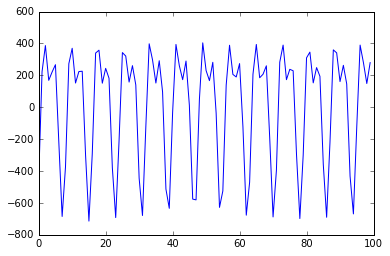

In [93]:
plot(x[:100])